In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline
import matplotlib.pyplot as plt


# This notebook is coped from this page:
# https://keras.io/examples/generative/vae/
# It shows how to make a variational auto-encoder that can model and generate
# hand-written digits 0-9; this is a standard machine learning test data set

In [2]:
# CAN EXPLORE THE EFFECT OF CHANGING THIS NUMBER FROM E.G. 2 .. 6.
# It is the number of dimensions into which the data is compressed
latent_dim = 2


In [3]:
class Sampling(layers.Layer):
    """
    This is a new layer type that is added to the 
    Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    """

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# The encoder network

# The 28 x 28 is the shape of the images of the digits, so we will
# have to change that for our purposes. We can make our n(z) into a 6 x 78 shape
# instead.
encoder_inputs = keras.Input(shape=(28, 28, 1))

# These x values are the different layers in the neural network. They will need to change
# for the n(z) estimation case. Could probably replace them with dense layers like the one below,
# or possibly just change the "3" to a new shape that makes sense for us. Since our "image" is a 
# very wide and short one (6 x 78) then maybe a shape that is similarly wider than tall would make sense.
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

2022-01-12 12:09:37.971342: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [6]:
# This is the model class. You hopefully won't have to modify this at all.

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # encode and decode again
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # loss value from how different our reconstruction
            # looks from the data
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            
            # loss from how different the z values are from a normal distribution
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # Total is the sum of these two
            total_loss = reconstruction_loss + kl_loss

        # do the training step update
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
# This is the MNIST data set, which is the set of hand-written digits.
# You will need to put our realizations into a similar format.
# Note that the values are normalized to the range 0 .. 1
# (That's what the 255 is doing).

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

print(mnist_digits.shape)
print(mnist_digits.dtype)
print(mnist_digits.min(), mnist_digits.max())


(70000, 28, 28, 1)
float32
0.0 1.0


In [8]:
# Now we actually build, prepare, and train the model.
# Change the number of epochs to 20 or 30 for a better model fit, but slower

# This will take several minutes (at least) to run, depending on the machine.
# It will be much faster on a GPU machine. It's about 7 minutes on my laptop.
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
# batch size is the amount of data to train on at once. Might need to decrease it if
# we run out of memory, or be able to decrease it if we have lots spare.
vae.fit(mnist_digits, epochs=10, batch_size=128)

2022-01-12 12:09:39.009799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
547/547 [==============================] - 41s 74ms/step - loss: 254.2276 - reconstruction_loss: 203.5409 - kl_loss: 4.3303
Epoch 2/10
547/547 [==============================] - 41s 75ms/step - loss: 174.0670 - reconstruction_loss: 164.7980 - kl_loss: 5.9771
Epoch 3/10
547/547 [==============================] - 40s 73ms/step - loss: 164.9156 - reconstruction_loss: 157.5379 - kl_loss: 6.1837
Epoch 4/10
547/547 [==============================] - 40s 74ms/step - loss: 160.9795 - reconstruction_loss: 153.9631 - kl_loss: 6.3018
Epoch 5/10
547/547 [==============================] - 39s 72ms/step - loss: 158.3832 - reconstruction_loss: 151.7480 - kl_loss: 6.3594
Epoch 6/10
547/547 [==============================] - 39s 72ms/step - loss: 156.6997 - reconstruction_loss: 150.1345 - kl_loss: 6.4345
Epoch 7/10
547/547 [==============================] - 40s 74ms/step - loss: 155.6885 - reconstruction_loss: 149.1122 - kl_loss: 6.4610
Epoch 8/10
547/547 [==============================] - 4

/var/folders/j5/3x141pqx72x6x622lgmrn95r0000gp/T/ipykernel_7107/4207972039.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(1, 1))


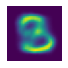

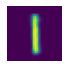

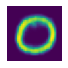

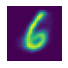

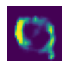

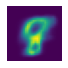

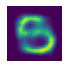

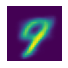

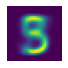

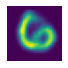

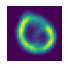

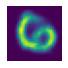

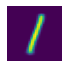

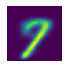

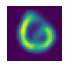

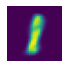

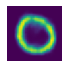

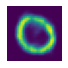

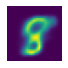

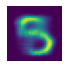

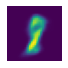

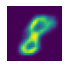

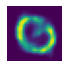

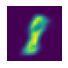

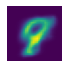

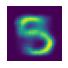

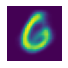

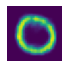

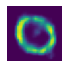

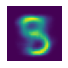

In [9]:
# Now we can use our trained model to generate random new digits.
# Some of them will be intermediate between actual digits!

# how many digits to make
n = 30

# random inputs for the decoding step
z_sample = np.random.normal(size=(n, 2))
# generated digit data
x_decoded = vae.decoder.predict(z_sample)
for i in range(n):
    plt.figure(figsize=(1, 1))
    plt.imshow(x_decoded[i])
    plt.axis('off')